In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

%matplotlib inline

## Part 1 - Exploratory Data Analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

#### Read the data

In [2]:
# read the data
logins = pd.read_json('logins.json', convert_dates=True)
# make login_time the index (for resampling)
logins.index = logins['login_time']
# make a num_login column (1s for now - will sum later)
logins['num_login'] = 1
# drop the login_time column
logins.drop('login_time', axis=1, inplace=True)

display(logins.head())

,num_login
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


#### Resample to 15 minute intervals

In [3]:
# resample to 15 minute intervals
logins_15 = logins.resample('15T').sum()

display(logins_15.head())
display(logins_15.describe())

,num_login
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


,num_login
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


#### Plot the time series

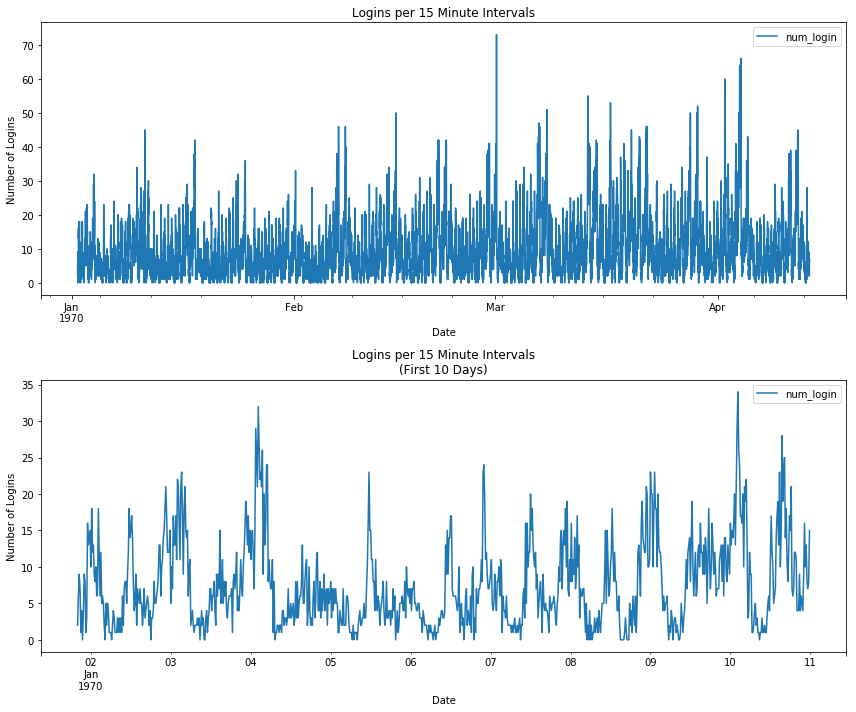

In [4]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

_ = logins_15.plot(ax=axes[0])
_ = logins_15[:'1970-1-10'].plot(ax=axes[1])

_ = axes[0].set(xlabel='Date', ylabel='Number of Logins', 
                title='Logins per 15 Minute Intervals')

_ = axes[1].set(xlabel='Date', ylabel='Number of Logins', 
                title='Logins per 15 Minute Intervals\n(First 10 Days)')

fig.tight_layout()

#### Plot logins by day of week

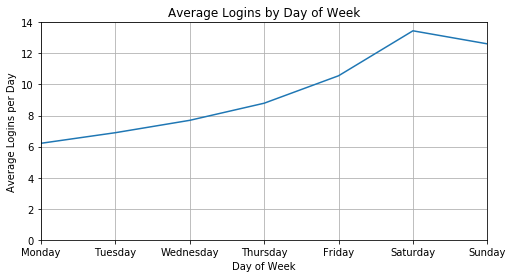

In [5]:
logins_15['day_of_week'] = logins_15.index.dayofweek

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

_ = logins_15.groupby('day_of_week').mean()['num_login'].plot(ax=ax, legend=False)

_ = ax.set_xticks(range(7))
_ = ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                        'Friday', 'Saturday', 'Sunday'])
_ = ax.set(xlabel='Day of Week', ylabel='Average Logins per Day',
           title='Average Logins by Day of Week')
_ = ax.grid()
_ = ax.set_xlim([0, 6])
_ = ax.set_ylim([0, 14])

#### Plot logins by hour

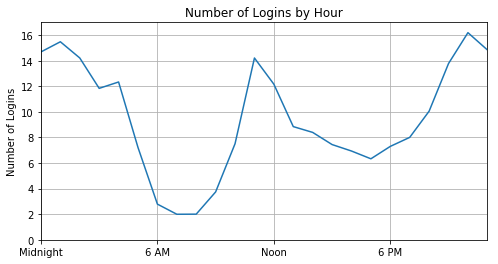

In [6]:
logins_15['hour'] = logins_15.index.hour

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

_ = logins_15.groupby('hour').mean()['num_login'].plot(ax=ax)

_ = ax.grid()
_ = ax.set(xlabel='', ylabel='Number of Logins', 
           title='Number of Logins by Hour')
_ = ax.set_xticks([0, 6, 12, 18])
_ = ax.set_xticklabels(['Midnight', '6 AM', 'Noon', '6 PM'])
_ = ax.set_xlim([0, 23])
_ = ax.set_ylim([0, 17])

## Part 2 - Experiment and Metrics Design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs. 
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:  
 a. how you will implement the experiment  
 b. what statistical test(s) you will conduct to verify the significance of the observation  
 c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

### Answer:
#### 1. 
For this problem, my key metric of interest would be the number (or percentage) of driver partners that cross the toll bridge before and after the reimbursement experiment start date. Since the problem mentions that driver partners tend to be exclusive to each city due to the two-way toll, data on driver partners currently crossing the toll bridge must be available. Comparing the number of driver partners crossing the toll bridge before and after the reimbursement experiment would give a clear picture as to whether the experiment was a success or failure.

#### 2. 
For this experiment, I would perform a two sample hypothesis test on the average daily number of driver partners that cross the toll bridge before and after the experiment. The hypothesis test would look like this:

$$H_0: \mu_b \ge \mu_a$$
$$H_a: \mu_b \lt \mu_a$$

where $\mu_b$ is the average daily number of driver partners that cross the toll bridge before the experiment, and $\mu_a$ is the average daily number of driver partners that cross the toll bridge after the experiment. 

An upper-tailed paired sample t-test will be used to compare the means of the before and after samples. If we are able to reject the null hypothesis with a 95% confidence level, then we can provide the city with statistical proof that the experiment was a success, and that driver partners are taking advantage of the toll reimbursement.

The experiment as detailed above assumes that data for driver partners crossing the bridge is available before the implementation of the toll reimbursement experiment. If this data turns out to be unavailable, the experiment will need to be redesigned to accommodate using the number of toll reimbursements. An unfortunate side effect of using this data will be that there are zero reimbursements before the experiment.

## Part 3 - Predictive Modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. 

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

In [7]:
# load the json data
data = json.load((open('ultimate_data_challenge.json')))
# convert json to dataframe
data = pd.io.json.json_normalize(data)
# reorder the rows 
data = data[['city', 'phone', 'signup_date', 'last_trip_date', 'avg_dist',
             'avg_rating_by_driver', 'avg_rating_of_driver', 'surge_pct', 
             'avg_surge', 'trips_in_first_30_days', 'ultimate_black_user',
             'weekday_pct']]
# add a retained column
data['retained'] = data['trips_in_first_30_days'] > 0
# convert signup_date and last_trip_date to datetimes
for col in ['signup_date', 'last_trip_date']:
    data[col] = pd.to_datetime(data[col])

data.head()

,city,phone,signup_date,last_trip_date,avg_dist,avg_rating_by_driver,avg_rating_of_driver,surge_pct,avg_surge,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,King's Landing,iPhone,2014-01-25,2014-06-17,3.67,5.0,4.7,15.4,1.10,4,True,46.2,True
1,Astapor,Android,2014-01-29,2014-05-05,8.26,5.0,5.0,0.0,1.00,0,False,50.0,False
2,Astapor,iPhone,2014-01-06,2014-01-07,0.77,5.0,4.3,0.0,1.00,3,False,100.0,True
3,King's Landing,iPhone,2014-01-10,2014-06-29,2.36,4.9,4.6,20.0,1.14,9,True,80.0,True
4,Winterfell,Android,2014-01-27,2014-03-15,3.13,4.9,4.4,11.8,1.19,14,False,82.4,True


In [8]:
print('Percentage of retained users: {:.4}%'.format(data['retained'].mean() * 100))

Percentage of retained users: 69.22%


Almost 70% of customers were "retained" meaning that they took at least one trip in the first 30 days after signup.

In [9]:
print('First Signup: {}\nLast Signup: {}'.format(data['signup_date'].min(), 
                                                 data['signup_date'].max()))

print('\nLast Trip Max: {}'.format(data['last_trip_date'].max()))

First Signup: 2014-01-01 00:00:00
Last Signup: 2014-01-31 00:00:00

Last Trip Max: 2014-07-01 00:00:00


In [10]:
print('Missing data by column: \n{}'.format(data.isnull().sum()))

Missing data by column: 
city                         0
phone                      396
signup_date                  0
last_trip_date               0
avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
surge_pct                    0
avg_surge                    0
trips_in_first_30_days       0
ultimate_black_user          0
weekday_pct                  0
retained                     0
dtype: int64


I'll start by filling in the missing *phone* observations. I could fill by the most frequent device used, but there actually may be a reason why the values are missing. Maybe they are windows phones? I'll simply fill the missing values with "other".

In [11]:
data['phone'].fillna('other', inplace=True)
print('Missing data by column: \n{}'.format(data.isnull().sum()))

Missing data by column: 
city                         0
phone                        0
signup_date                  0
last_trip_date               0
avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
surge_pct                    0
avg_surge                    0
trips_in_first_30_days       0
ultimate_black_user          0
weekday_pct                  0
retained                     0
dtype: int64


Next I'll fill in the numerical values of *avg_rating_by_driver* and *avg_rating_of_driver* by simply using the mean.

In [12]:
from sklearn.preprocessing import Imputer

imp = Imputer()

data[['avg_rating_by_driver', 'avg_rating_of_driver']] = \
    imp.fit_transform(data[['avg_rating_by_driver', 
                            'avg_rating_of_driver']])

print('Missing data by column: \n{}'.format(data.isnull().sum()))

Missing data by column: 
city                      0
phone                     0
signup_date               0
last_trip_date            0
avg_dist                  0
avg_rating_by_driver      0
avg_rating_of_driver      0
surge_pct                 0
avg_surge                 0
trips_in_first_30_days    0
ultimate_black_user       0
weekday_pct               0
retained                  0
dtype: int64


I'm going to perform two predictions based on this data. The first is to predict whether a user will be "retained" or not. The second will predict whether or not a user will be active in their 6th month after signup. 

### Encoding categorical variables
The only categorical variables are *city* and *phone*. I'll use `pd.get_dummies()` to encode these variables. ~~*Note*: I'm dropping the first column of each encoded categorical variable to avoid the "dummy variable trap".~~

In [13]:
data = pd.get_dummies(data)

data.head()

,signup_date,last_trip_date,avg_dist,avg_rating_by_driver,avg_rating_of_driver,surge_pct,avg_surge,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_other
0,2014-01-25,2014-06-17,3.67,5.0,4.7,15.4,1.10,4,True,46.2,True,0,1,0,0,1,0
1,2014-01-29,2014-05-05,8.26,5.0,5.0,0.0,1.00,0,False,50.0,False,1,0,0,1,0,0
2,2014-01-06,2014-01-07,0.77,5.0,4.3,0.0,1.00,3,False,100.0,True,1,0,0,0,1,0
3,2014-01-10,2014-06-29,2.36,4.9,4.6,20.0,1.14,9,True,80.0,True,0,1,0,0,1,0
4,2014-01-27,2014-03-15,3.13,4.9,4.4,11.8,1.19,14,False,82.4,True,0,0,1,1,0,0


#### Predicting "retained"
To avoid data leakage, I'll need to exclude the *trips_in_first_30_days* columns since that's what the target variable was constructed from. Also, *signup_date* and *last_trip_date* are datetimes which we won't be able to use in a predictive model (although time deltas may come in handy later).

In [14]:
data.head()

,signup_date,last_trip_date,avg_dist,avg_rating_by_driver,avg_rating_of_driver,surge_pct,avg_surge,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_other
0,2014-01-25,2014-06-17,3.67,5.0,4.7,15.4,1.10,4,True,46.2,True,0,1,0,0,1,0
1,2014-01-29,2014-05-05,8.26,5.0,5.0,0.0,1.00,0,False,50.0,False,1,0,0,1,0,0
2,2014-01-06,2014-01-07,0.77,5.0,4.3,0.0,1.00,3,False,100.0,True,1,0,0,0,1,0
3,2014-01-10,2014-06-29,2.36,4.9,4.6,20.0,1.14,9,True,80.0,True,0,1,0,0,1,0
4,2014-01-27,2014-03-15,3.13,4.9,4.4,11.8,1.19,14,False,82.4,True,0,0,1,1,0,0


In [15]:
cols_to_drop = ['signup_date', 'last_trip_date', 'trips_in_first_30_days', 'retained']

cols_to_scale = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'surge_pct',
                 'avg_surge', 'trips_in_first_30_days', 'weekday_pct']

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

data_scaled = data.copy()

data_scaled[cols_to_scale] = scaler.fit_transform(data[cols_to_scale])

data_scaled.head()

,signup_date,last_trip_date,avg_dist,avg_rating_by_driver,avg_rating_of_driver,surge_pct,avg_surge,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_other
0,2014-01-25,2014-06-17,-0.372650,0.497684,0.174240,0.328202,0.113506,0.453984,True,-0.397131,True,0,1,0,0,1,0
1,2014-01-29,2014-05-05,0.431583,0.497684,0.705241,-0.443394,-0.336268,-0.600689,False,-0.294653,False,1,0,0,1,0,0
2,2014-01-06,2014-01-07,-0.880771,0.497684,-0.533761,-0.443394,-0.336268,0.190316,False,1.053741,True,1,0,0,0,1,0
3,2014-01-10,2014-06-29,-0.602181,0.273342,-0.002760,0.558679,0.293416,1.772325,True,0.514383,True,0,1,0,0,1,0
4,2014-01-27,2014-03-15,-0.467266,0.273342,-0.356760,0.147829,0.518303,3.090665,False,0.579106,True,0,0,1,1,0,0


#### Balancing the classes

In [17]:
from sklearn.utils import resample

majority = data_scaled[data_scaled['retained'] == True]
minority = data_scaled[data_scaled['retained'] == False]

majority_length = len(majority)
minority_length = len(minority)

minority_upsampled = resample(minority, replace=True, 
                              n_samples=(majority_length - minority_length),
                              random_state=42)

data_balanced = pd.concat([majority, minority, minority_upsampled])

In [18]:
# construct X and y with necessary columns
X = data_balanced.drop(cols_to_drop, axis=1)
y = data_balanced['retained']

print(X.shape, y.shape)

(69220, 13) (69220,)


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

print(X_train.shape, X_test.shape)

(48454, 13) (20766, 13)


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

models = {
    'LogisticRegression': LogisticRegression(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier()
}

params = {
    'LogisticRegression': {'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    'KNeighborsClassifier': {'n_neighbors': [10, 25, 50, 100]},
    'DecisionTreeClassifier': {'max_depth': [5, 10, 20],
                               'min_samples_split': [5, 10, 20],
                               'min_samples_leaf': [5, 10, 20]},
    'RandomForestClassifier': {'n_estimators': [100, 250],
                               'max_depth': [10, 20, 40],
                               'min_samples_split': [5, 10, 20],
                               'min_samples_leaf': [20, 40]},
    'AdaBoostClassifier': {'n_estimators': [100, 250, 500],
                           'learning_rate': [0.01, 0.1, 1, 10]}
}

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

best_test = 0

for model in models.keys():
    print('Grid Search for {}'.format(model))
    gs = GridSearchCV(models[model], params[model], n_jobs=4, verbose=1)
    gs.fit(X_train, y_train)
    print('Best params: {}'.format(gs.best_params_))
    print('Best cv score: {}'.format(gs.best_score_))
    print('Best test score: {}'.format(gs.best_estimator_.score(X_test, y_test)))
    print('Confusion Matrix: \n{}'.format(confusion_matrix(y_test, gs.best_estimator_.predict(X_test))))
    y_pred = gs.best_estimator_.predict(X_test)
    print('Precision Score: {}'.format(precision_score(y_test, y_pred)))
    print('Recall Score: {}'.format(recall_score(y_test, y_pred)))
    print('F1 Score: {}'.format(f1_score(y_test, y_pred)))
    print('\n\n')
    if gs.best_estimator_.score(X_test, y_test) > best_test:
        best_test = gs.best_estimator_.score(X_test, y_test)
        best_model = gs.best_estimator_

Grid Search for LogisticRegression
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:    1.1s finished


Best params: {'C': 0.001}
Best cv score: 0.554195732034507
Best test score: 0.555330829240104
Confusion Matrix: 
[[5441 4942]
 [4292 6091]]
Precision Score: 0.5520710595486269
Recall Score: 0.5866319946065685
F1 Score: 0.5688270451998506



Grid Search for KNeighborsClassifier
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:   30.2s finished


Best params: {'n_neighbors': 10}
Best cv score: 0.624406653733438
Best test score: 0.6346431667148223
Confusion Matrix: 
[[7679 2704]
 [4883 5500]]
Precision Score: 0.6704046806435885
Recall Score: 0.5297120292786285
F1 Score: 0.5918114811427341



Grid Search for DecisionTreeClassifier
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=4)]: Done  74 out of  81 | elapsed:    2.6s remaining:    0.3s
[Parallel(n_jobs=4)]: Done  81 out of  81 | elapsed:    2.8s finished


Best params: {'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 10}
Best cv score: 0.6438064968836422
Best test score: 0.671385919291149
Confusion Matrix: 
[[7729 2654]
 [4170 6213]]
Precision Score: 0.7006879440622533
Recall Score: 0.5983819705287489
F1 Score: 0.6455064935064935



Grid Search for RandomForestClassifier
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   38.1s
[Parallel(n_jobs=4)]: Done 108 out of 108 | elapsed:  1.6min finished


Best params: {'max_depth': 20, 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 100}
Best cv score: 0.6467577496181945
Best test score: 0.652412597515169
Confusion Matrix: 
[[7644 2739]
 [4479 5904]]
Precision Score: 0.6830961471711211
Recall Score: 0.5686217856110951
F1 Score: 0.6206244087038789



Grid Search for AdaBoostClassifier
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:  1.1min finished


Best params: {'learning_rate': 1, 'n_estimators': 250}
Best cv score: 0.6347463573698766
Best test score: 0.6356062794953289
Confusion Matrix: 
[[7555 2828]
 [4739 5644]]
Precision Score: 0.666194523135033
Recall Score: 0.5435808533179235
F1 Score: 0.5986740917528507





In [22]:
print('Feature Importance')
for i, col in enumerate(X_train.columns):
    print('{}: {:.4}'.format(col, best_model.feature_importances_[i]))

Feature Importance
avg_dist: 0.4316
avg_rating_by_driver: 0.146
avg_rating_of_driver: 0.09344
surge_pct: 0.05626
avg_surge: 0.04263
ultimate_black_user: 0.03018
weekday_pct: 0.1275
city_Astapor: 0.01542
city_King's Landing: 0.0119
city_Winterfell: 0.01711
phone_Android: 0.01168
phone_iPhone: 0.01403
phone_other: 0.002244


#### Predicting 6th month activity

In [23]:
from datetime import timedelta

# create a column, tenure, for last_trip_date - signup_date
# anything >150 is active in the 6th month
data_scaled['tenure'] = data_scaled['last_trip_date'] - data_scaled['signup_date']
# now create a boolean column for active in 6th month
data_scaled['active_6m'] = data_scaled['tenure'] >= timedelta(days=150)

data_scaled.head()

,signup_date,last_trip_date,avg_dist,avg_rating_by_driver,avg_rating_of_driver,surge_pct,avg_surge,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_other,tenure,active_6m
0,2014-01-25,2014-06-17,-0.372650,0.497684,0.174240,0.328202,0.113506,0.453984,True,-0.397131,True,0,1,0,0,1,0,143 days,False
1,2014-01-29,2014-05-05,0.431583,0.497684,0.705241,-0.443394,-0.336268,-0.600689,False,-0.294653,False,1,0,0,1,0,0,96 days,False
2,2014-01-06,2014-01-07,-0.880771,0.497684,-0.533761,-0.443394,-0.336268,0.190316,False,1.053741,True,1,0,0,0,1,0,1 days,False
3,2014-01-10,2014-06-29,-0.602181,0.273342,-0.002760,0.558679,0.293416,1.772325,True,0.514383,True,0,1,0,0,1,0,170 days,True
4,2014-01-27,2014-03-15,-0.467266,0.273342,-0.356760,0.147829,0.518303,3.090665,False,0.579106,True,0,0,1,1,0,0,47 days,False


In [24]:
data_scaled['active_6m'].mean()

0.25428

About 25% of users were active in their 6th month.

In [25]:
from sklearn.utils import resample

cols_to_drop = ['signup_date', 'last_trip_date', 'tenure', 'active_6m']

majority = data_scaled[data_scaled['active_6m'] == False]
minority = data_scaled[data_scaled['active_6m'] == True]

majority_length = len(majority)
minority_length = len(minority)

minority_upsampled = resample(minority, replace=True, 
                              n_samples=(majority_length - minority_length),
                              random_state=42)

data_balanced = pd.concat([majority, minority, minority_upsampled])

In [26]:
# construct X and y with necessary columns
X = data_balanced.drop(cols_to_drop, axis=1)
y = data_balanced['active_6m']

print(X.shape, y.shape)

(74572, 15) (74572,)


In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

print(X_train.shape, X_test.shape)

(52200, 15) (22372, 15)


In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

best_test = 0

for model in models.keys():
    print('Grid Search for {}'.format(model))
    gs = GridSearchCV(models[model], params[model], n_jobs=-1, verbose=1)
    gs.fit(X_train, y_train)
    print('Best params: {}'.format(gs.best_params_))
    print('Best cv score: {}'.format(gs.best_score_))
    print('Best test score: {}'.format(gs.best_estimator_.score(X_test, y_test)))
    print('Confusion Matrix: \n{}'.format(confusion_matrix(y_test, gs.best_estimator_.predict(X_test))))
    y_pred = gs.best_estimator_.predict(X_test)
    print('Precision Score: {}'.format(precision_score(y_test, y_pred)))
    print('Recall Score: {}'.format(recall_score(y_test, y_pred)))
    print('F1 Score: {}'.format(f1_score(y_test, y_pred)))
    print('\n\n')
    if gs.best_estimator_.score(X_test, y_test) > best_test:
        best_test = gs.best_estimator_.score(X_test, y_test)
        best_model = gs.best_estimator_

Grid Search for LogisticRegression
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.0s finished


Best params: {'C': 0.1}
Best cv score: 0.6730842911877395
Best test score: 0.6783479349186483
Confusion Matrix: 
[[7908 3278]
 [3918 7268]]
Precision Score: 0.6891712497629433
Recall Score: 0.6497407473627749
F1 Score: 0.6688753911282901



Grid Search for KNeighborsClassifier
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   40.9s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   44.4s finished


Best params: {'n_neighbors': 10}
Best cv score: 0.7332183908045977
Best test score: 0.7440997675666011
Confusion Matrix: 
[[8239 2947]
 [2778 8408]]
Precision Score: 0.7404667547335976
Recall Score: 0.751653853030574
F1 Score: 0.7460183665320971



Grid Search for DecisionTreeClassifier
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  66 out of  81 | elapsed:    2.5s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    2.8s finished


Best params: {'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 5}
Best cv score: 0.7560536398467433
Best test score: 0.7779367065975327
Confusion Matrix: 
[[8485 2701]
 [2267 8919]]
Precision Score: 0.7675559380378657
Recall Score: 0.7973359556588593
F1 Score: 0.7821625887924232



Grid Search for RandomForestClassifier
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  1.5min finished


Best params: {'max_depth': 20, 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 250}
Best cv score: 0.7616091954022989
Best test score: 0.7660468442696228
Confusion Matrix: 
[[8480 2706]
 [2528 8658]]
Precision Score: 0.7618796198521647
Recall Score: 0.7740032183086001
F1 Score: 0.7678935698447893



Grid Search for AdaBoostClassifier
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   47.1s finished


Best params: {'learning_rate': 1, 'n_estimators': 250}
Best cv score: 0.748007662835249
Best test score: 0.7527266225639192
Confusion Matrix: 
[[8509 2677]
 [2855 8331]]
Precision Score: 0.756813226744186
Recall Score: 0.7447702485249419
F1 Score: 0.7507434441741012





In [29]:
print(best_model)
y_pred = best_model.predict(X_test)
print('\nTest Accuracy: {}'.format(best_model.score(X_test, y_test)))
print('Precision Score: {}'.format(precision_score(y_pred, y_test)))
print('Recall Score: {}'.format(recall_score(y_pred, y_test)))
print('F1 Score: {}'.format(f1_score(y_pred, y_test)))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Test Accuracy: 0.7779367065975327
Precision Score: 0.7973359556588593
Recall Score: 0.7675559380378657
F1 Score: 0.7821625887924232


In [30]:
print('Feature Importance')
for i, col in enumerate(X_train.columns):
    print('{}: {:.4}'.format(col, best_model.feature_importances_[i]))

Feature Importance
avg_dist: 0.2534
avg_rating_by_driver: 0.234
avg_rating_of_driver: 0.06305
surge_pct: 0.08269
avg_surge: 0.03567
trips_in_first_30_days: 0.04706
ultimate_black_user: 0.02757
weekday_pct: 0.1175
retained: 0.008135
city_Astapor: 0.01217
city_King's Landing: 0.07345
city_Winterfell: 0.009163
phone_Android: 0.01212
phone_iPhone: 0.02384
phone_other: 0.0001935


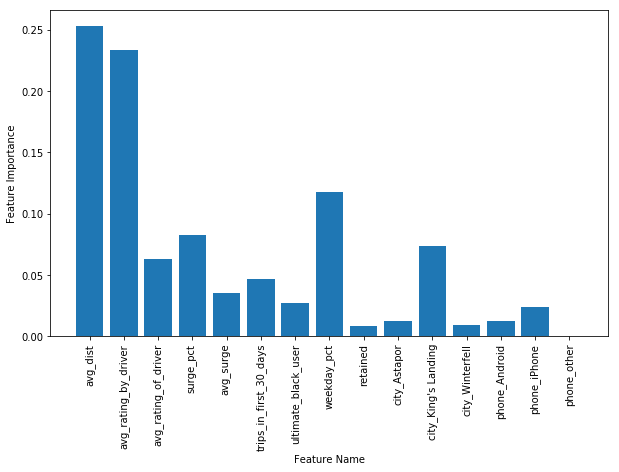

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

_ = ax.bar(X_train.columns, best_model.feature_importances_)
_ = ax.set(xlabel='Feature Name', ylabel='Feature Importance')
_ = plt.xticks(rotation=90)

So again the best model is a simple decision tree classifier which achieves a 77.5% accuracy of predicting if a user will be active in their 6th month. The 3 most important features for this model are average distance of trip, average rating of user by the driver, and what percentage of the trips are taken during the weekday.

With this information, Ultimate could focus marketing efforts on retention of users that take long trips on weekdays to increase the likelihood that these users will stay active up to and past 6 months. Additionally, Ultimate could take actions which increase a users change of taking long trips. This could include discounts for longer trips/weekday trips or a perk package to keep these users engaged.